 Dos ejecutivos de Airbnb están discutiendo respecto a cuáles son las zonas con más 
departamentos en Airbnb. Les ofreces hacer un análisis con buen nivel de detalle 
para enviarles un informe respecto a esto. Ellos dicen que no tienen tiempo de 
leerlo, que solo quieren ver una foto, imagen o tabla que les permita saberlo 
rápidamente. ¿Qué les muestras? (Desarrollar en código)

In [1]:

# Con Spark SQL, ejecuta la consulta en lakehouse, que se encuentra en la misma área de trabajo que el lakehouse predeterminado actual.

df = spark.sql("SELECT * FROM DataflowakehouseMerovingian.neighbourhoods LIMIT 1000")
display(df)

StatementMeta(, 40fbbd42-14d9-4fd4-8128-bdc929444701, 3, Finished, Available)

SynapseWidget(Synapse.DataFrame, 6c939549-00eb-4738-a718-663bc6777953)

In [2]:
df_neighbourhood = spark.sql("SELECT neighbourhood,latitude,longitude,neighbourhood_cleansed,neighbourhood_group_cleansed,neighborhood_overview FROM DataflowakehouseMerovingian.listings  WHERE latitude IS NOT NULL AND longitude IS NOT NULL")
df_neighbourhood.printSchema()

StatementMeta(, 40fbbd42-14d9-4fd4-8128-bdc929444701, 4, Finished, Available)

root
 |-- neighbourhood: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- neighbourhood_cleansed: string (nullable = true)
 |-- neighbourhood_group_cleansed: string (nullable = true)
 |-- neighborhood_overview: string (nullable = true)



In [3]:
from pyspark.sql.functions import count, avg, col
from pyspark.sql.types import DoubleType
# Convertir las columnas de latitud y longitud a tipo numérico
df_neighbourhood_reset = df_neighbourhood.withColumn("latitude", col("latitude").cast(DoubleType())).withColumn("longitude", col("longitude").cast(DoubleType()))
display(df_neighbourhood_reset)


StatementMeta(, 40fbbd42-14d9-4fd4-8128-bdc929444701, 5, Finished, Available)

SynapseWidget(Synapse.DataFrame, c71fdcac-1102-4b3d-880a-af0d082a2e0a)

Desarrollamos una simple seleccion de los 3 campos de interes **neighbourhood_cleansed** , **latitude** , **longitude**.

In [4]:
neighbourhoods_df = spark.sql("""
    SELECT neighbourhood_cleansed, latitude, longitude
    FROM DataflowakehouseMerovingian.listings
    WHERE LENGTH(neighbourhood_cleansed) > 5 AND LENGTH(neighbourhood_cleansed) < 22
    AND latitude BETWEEN 47 AND 49
""")

# Mostrar los primeros registros del DataFrame
neighbourhoods_df.show()


StatementMeta(, 40fbbd42-14d9-4fd4-8128-bdc929444701, 6, Finished, Available)

+----------------------+------------------+------------------+
|neighbourhood_cleansed|          latitude|         longitude|
+----------------------+------------------+------------------+
|     Buttes-Montmartre|          48.88774|           2.34429|
|          Ménilmontant|          48.85421|           2.40933|
|     Buttes-Montmartre|          48.88843|           2.32616|
|              Entrepôt|          48.87265|           2.34827|
|             Vaugirard|          48.83411|           2.30915|
|          Ménilmontant|           48.8681|           2.39962|
|                Temple|          48.85915|           2.36321|
|        Palais-Bourbon|          48.85767|           2.30432|
|                Louvre|          48.86063|           2.34056|
|              Entrepôt|          48.87374|           2.35543|
|             Vaugirard|          48.84933|           2.29494|
|            Luxembourg|          48.85253|           2.33375|
|        Palais-Bourbon|          48.85611|           2

Aqui observamos que tenemos que realizar una limpieza para los campos de neighbourhood_cleansed

In [5]:

# Agrupar por barrio y calcular las métricas deseadas
neighbourhood_metrics = neighbourhoods_df.groupBy("neighbourhood_cleansed") \
                          .agg(count("*").alias("total_listings"),
                               avg("latitude").alias("avg_latitude"),
                               avg("longitude").alias("avg_longitude"))
# Mostrar el esquema y los primeros registros del DataFrame resultante
neighbourhood_metrics.printSchema()
neighbourhood_metrics.show()

StatementMeta(, 40fbbd42-14d9-4fd4-8128-bdc929444701, 7, Finished, Available)

root
 |-- neighbourhood_cleansed: string (nullable = true)
 |-- total_listings: long (nullable = false)
 |-- avg_latitude: double (nullable = true)
 |-- avg_longitude: double (nullable = true)

+----------------------+--------------+------------------+------------------+
|neighbourhood_cleansed|total_listings|      avg_latitude|     avg_longitude|
+----------------------+--------------+------------------+------------------+
|                Louvre|           735| 48.86308540890322| 2.341222807618984|
|                Temple|          1422| 48.86358675078207|2.3594636698705638|
|          Observatoire|          1757|48.827308395993605| 2.323685827299488|
|        Palais-Bourbon|           874|48.856146748777945|2.3123546066156395|
|            Luxembourg|           926| 48.85039381403395|2.3333330511485317|
|              Panthéon|          1166| 48.84492081968433| 2.349186910579067|
|            Popincourt|          3384|  48.8601708041848| 2.378462655023458|
|               Reuilly|  

Creamos una vista Temporal.

In [6]:
# Registrar el DataFrame como una tabla temporal para poder ejecutar consultas SQL
neighbourhoods_df.createOrReplaceTempView("Alojamientos_TempView")

StatementMeta(, 40fbbd42-14d9-4fd4-8128-bdc929444701, 8, Finished, Available)

Construimos una data frame para luego acceder con pandas y graficar.

In [7]:
import matplotlib.pyplot as plt

alojamientos_por_ciudad_df = spark.sql("""
SELECT neighbourhood_cleansed AS ciudad,
       COUNT(*) AS num_alojamientos,
       AVG(latitude) AS latitud_promedio,
       AVG(longitude) AS longitud_promedio
FROM Alojamientos_TempView
GROUP BY neighbourhood_cleansed
ORDER BY num_alojamientos DESC
LIMIT 20;

""")

# Convertir el DataFrame de Spark a un DataFrame de Pandas
alojamientos_por_ciudad_pd = alojamientos_por_ciudad_df.toPandas()

alojamientos_por_ciudad_df.show()


StatementMeta(, 40fbbd42-14d9-4fd4-8128-bdc929444701, 9, Finished, Available)

+-------------------+----------------+------------------+------------------+
|             ciudad|num_alojamientos|  latitud_promedio| longitud_promedio|
+-------------------+----------------+------------------+------------------+
|  Buttes-Montmartre|            4322| 48.89048011096534|2.3437376933863563|
|         Popincourt|            3384|  48.8601708041848| 2.378462655023458|
|          Vaugirard|            3158| 48.84008303691583| 2.294035812225563|
|Batignolles-Monceau|            3153|48.889081365308584| 2.307438888999719|
|    Buttes-Chaumont|            2551| 48.88555635939238|2.3858601935500707|
|       Ménilmontant|            2515| 48.86486051957772|2.4006382964680006|
|           Entrepôt|            2506| 48.87471924746889|2.3604876627483073|
|            Reuilly|            2487| 48.84098705409759|2.4104127279714844|
|       Observatoire|            1757|48.827308395993605| 2.323685827299488|
|           Gobelins|            1625|48.825632124445846|2.3607336215932393|

Desarrollamos las Graficas con Python

StatementMeta(, 40fbbd42-14d9-4fd4-8128-bdc929444701, 10, Finished, Available)

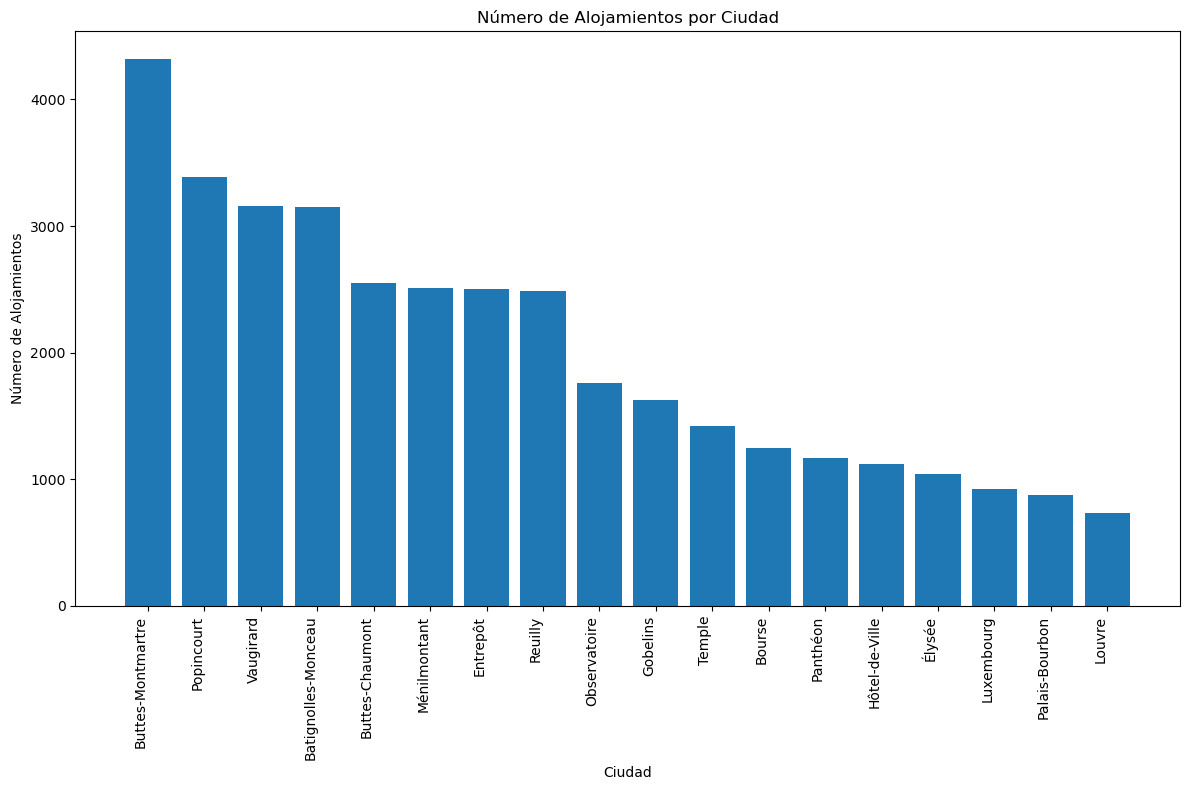

In [8]:

import matplotlib.pyplot as plt


# Crear un gráfico de barras con los resultados
plt.figure(figsize=(12, 8))
plt.bar(alojamientos_por_ciudad_pd['ciudad'], alojamientos_por_ciudad_pd['num_alojamientos'])
plt.title('Número de Alojamientos por Ciudad')
plt.xlabel('Ciudad')
plt.ylabel('Número de Alojamientos')
plt.xticks(rotation=90, ha='right')  # Rotar las etiquetas del eje x para mejorar la legibilidad
plt.tight_layout()

# Mostrar el gráfico
plt.show()


In [9]:
neighbourhoods_pd = neighbourhoods_df.toPandas()

StatementMeta(, 40fbbd42-14d9-4fd4-8128-bdc929444701, 11, Finished, Available)

In [10]:
pip install folium pandas

StatementMeta(, 40fbbd42-14d9-4fd4-8128-bdc929444701, 12, Finished, Available)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 28.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [11]:
import folium

# Convertir el DataFrame de Spark a Pandas si aún no lo has hecho
barrios_df = neighbourhoods_df.toPandas()

# Crear un mapa centrado en París
mapa_paris = folium.Map(location=[48.8566, 2.3522], zoom_start=12)

# Agregar marcadores para los primeros 1000 barrios
for index, row in barrios_df.head(100).iterrows():
    folium.Marker(
        [row['latitude'], row['longitude']], 
        popup=row['neighbourhood_cleansed']
    ).add_to(mapa_paris)

# Guardar el mapa en un archivo HTML
mapa_paris.save('airbnb_departamentos_por_barrio_mapa.html')

# Mostrar el mapa
mapa_paris



StatementMeta(, 40fbbd42-14d9-4fd4-8128-bdc929444701, 13, Finished, Available)

In [12]:
import folium
from folium.plugins import HeatMap

# Convertir el DataFrame de Spark a Pandas si aún no lo has hecho
barrios_df = neighbourhoods_df.toPandas()

# Crear un mapa centrado en París
mapa_paris = folium.Map(location=[48.8566, 2.3522], zoom_start=12)

# Preparar los datos para el mapa de calor
heat_data = [[row['latitude'], row['longitude']] for index, row in barrios_df.head(1000).iterrows()]

# Agregar el mapa de calor al mapa
HeatMap(heat_data, radius=15).add_to(mapa_paris)

# Guardar el mapa en un archivo HTML
mapa_paris.save('airbnb_departamentos_por_barrio_mapa_calor.html')

# Mostrar el mapa
mapa_paris


StatementMeta(, 40fbbd42-14d9-4fd4-8128-bdc929444701, 14, Finished, Available)

En otras ciudades del mundo, la gente está usando cada vez menos la aplicación. Al 
equipo ejecutivo en París le preocupa esto y quiere saber cómo es la situación en 
esa ciudad. Específicamente, le gustaría ver cómo fueron evolucionando la 
cantidad de reviews escritas a lo largo de los años.

In [13]:
df = spark.sql("SELECT * FROM DataflowakehouseMerovingian.reviews LIMIT 1000")
display(df)

StatementMeta(, 40fbbd42-14d9-4fd4-8128-bdc929444701, 15, Finished, Available)

SynapseWidget(Synapse.DataFrame, 8a0ab8c7-6bb1-451e-bdf2-9538a406add3)

Visualizar la cantidad de reseñas escritas en Airbnb París por año, lo que te dará una idea de cómo ha evolucionado la actividad en la plataforma en esta ciudad. Si observas una tendencia decreciente en los últimos años, podría ser una señal de que la gente está usando menos la aplicación, como se mencionó en tu consulta.

StatementMeta(, 40fbbd42-14d9-4fd4-8128-bdc929444701, 16, Finished, Available)

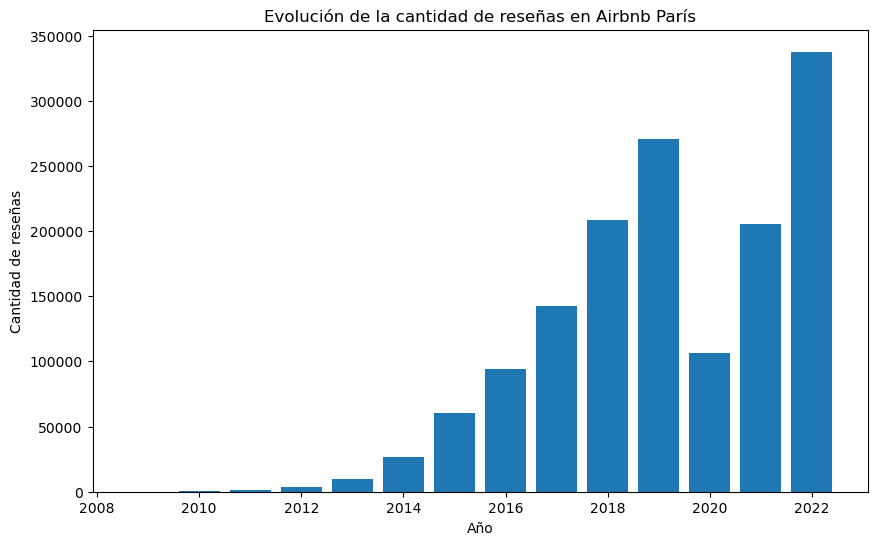

In [14]:

from pyspark.sql.functions import year

# Leer el dataset de reviews
df = spark.sql("SELECT * FROM DataflowakehouseMerovingian.reviews_summary")

# Extraer el año de la fecha y crear una nueva columna
df = df.withColumn("year", year("date"))

# Contar la cantidad de reseñas por año
reviews_per_year = df.groupBy("year").count().orderBy("year")

# Convertir el DataFrame de Spark a un DataFrame de Pandas para la visualización
reviews_per_year_pd = reviews_per_year.toPandas()
# Graficar la evolución de la cantidad de reseñas a lo largo de los años
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(reviews_per_year_pd["year"], reviews_per_year_pd["count"])
plt.title('Evolución de la cantidad de reseñas en Airbnb París')
plt.xlabel('Año')
plt.ylabel('Cantidad de reseñas')
plt.show()


Pero en este caso no vemos esto, se observa una actividad creciente en reseñas para 2022

El equipo de marketing está trabajando en una campaña global que consiste en 
mostrar cuáles son las principales palabras de viajeros asociadas a las principales 
ciudades del mundo. Les gustaría saber cuáles son las principales palabras que 
dicen de París (realiza la representación que prefieras para responder esta 
pregunta)

Una representación común para este tipo de análisis es una nube de palabras (word cloud), que visualiza las palabras más frecuentes con un tamaño proporcional a su frecuencia

Este código realiza los siguientes pasos:

1. Filtra las reseñas en inglés basándose en la presencia de palabras comunes en inglés.
2. Limpia el texto de las reseñas convirtiéndolo a minúsculas y eliminando la puntuación y los números.
3. Elimina las palabras comunes (stopwords) del texto de las reseñas.
4. Concatena todas las reseñas filtradas en un solo texto.

Después de estos pasos, puedes proceder a generar la nube de palabras como se mostró anteriormente. Esto debería darte una nube de palabras más representativa de las opiniones específicas sobre París, eliminando el ruido causado por palabras comunes y no relevantes.

In [15]:
from pyspark.sql.functions import concat_ws, collect_list, lower, regexp_replace, split, explode
from pyspark.ml.feature import StopWordsRemover

# Leer el dataset de reseñas
df = spark.sql("SELECT * FROM DataflowakehouseMerovingian.reviews")

# Filtrar reseñas en inglés (asumiendo que el idioma se puede inferir por la presencia de palabras comunes en inglés)
english_reviews = df.filter(lower(df.comments).rlike(r'\b(the|and|is|are|of)\b'))

# Limpiar el texto de las reseñas: convertir a minúsculas, eliminar puntuación y números
clean_reviews = english_reviews.withColumn("clean_comments", regexp_replace(lower("comments"), "[^a-zA-Z\\s]", ""))

# Dividir el texto limpio en una lista de palabras
word_list = clean_reviews.withColumn("words", split("clean_comments", "\\s+"))

# Remover palabras comunes (stopwords)
stopwords = StopWordsRemover.loadDefaultStopWords("english")
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words", stopWords=stopwords)
filtered_reviews = remover.transform(word_list)

# Aplanar la lista de listas de palabras filtradas
flattened_reviews = filtered_reviews.withColumn("flattened_words", explode("filtered_words"))

# Seleccionar y concatenar todas las palabras filtradas en un solo texto
all_reviews = flattened_reviews.select(concat_ws(" ", collect_list("flattened_words")).alias("all_comments")).first()["all_comments"]




StatementMeta(, 40fbbd42-14d9-4fd4-8128-bdc929444701, 17, Finished, Available)

In [16]:
pip install wordcloud


StatementMeta(, 40fbbd42-14d9-4fd4-8128-bdc929444701, 18, Finished, Available)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 kB 16.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Desarrollamos la nube de palabras

StatementMeta(, 40fbbd42-14d9-4fd4-8128-bdc929444701, 19, Finished, Available)

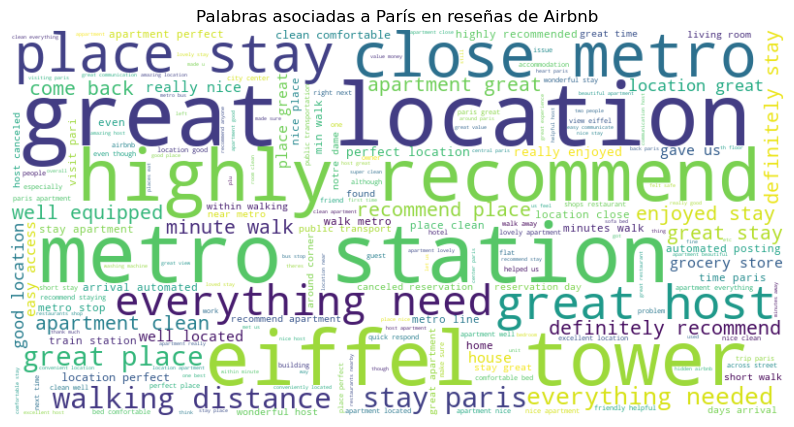

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Crear y generar una nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

# Mostrar la nube de palabras generada
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palabras asociadas a París en reseñas de Airbnb')
plt.show()

La inflación está haciendo estragos en Europa y al equipo ejecutivo le interesa saber 
cuál es la concepción de esto entre los propietarios de alojamientos. En otras 
palabras, les interesa saber si ya están teniendo en cuenta el aumento de precios a 
futuro en sus departamentos y existe una tendencia alcista en los precios que 
publican en Airbnb, o si no le están dando mayor importancia y los precios se ven 
bastante estáticos a futuro. La pregunta que escuchaste a un ejecutivo decir es: 
"¿Los inquilinos están planificando aumentar los precios?". (Siéntete libre de 
responderla de la forma que quieras, a partir de correr algún análisis estadístico, 
representación gráfica, etc. Para esta pregunta, puedes consultar el dataset
“calendar.csv” que incluye, para cada propiedad, el precio definido día a día para el 
próximo año).

StatementMeta(, 40fbbd42-14d9-4fd4-8128-bdc929444701, 20, Finished, Available)

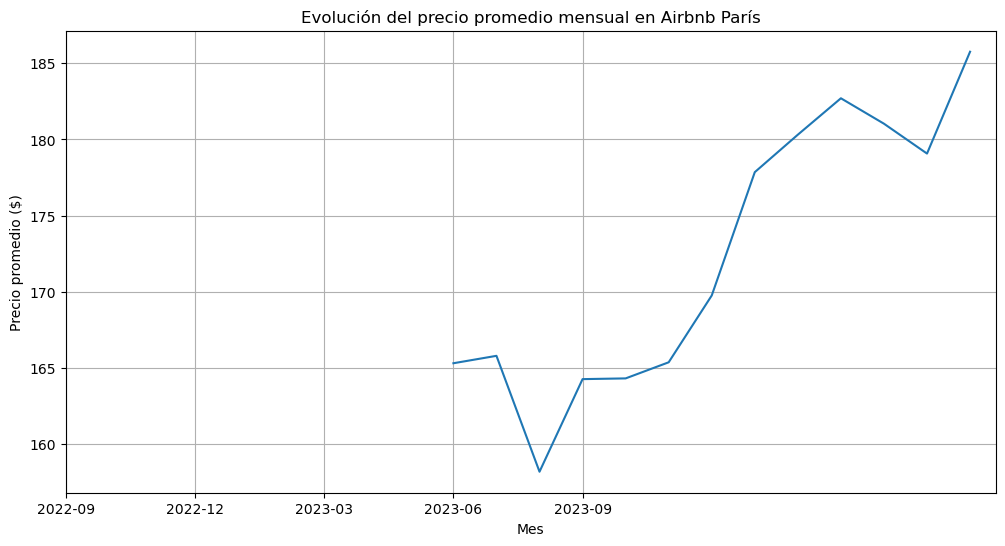

In [18]:
from pyspark.sql.functions import to_date, month, year, avg
from pyspark.sql.types import FloatType
import matplotlib.pyplot as plt

# Leer el dataset de calendar
df = spark.sql("SELECT * FROM DataflowakehouseMerovingian.calendar")

# Convertir la columna 'date' a tipo fecha
calendar_df = df.withColumn("date", to_date("date", "yyyy-MM-dd"))

# Convertir la columna 'price' a tipo float, asegurándose de limpiar el campo de caracteres no numéricos
calendar_df = calendar_df.withColumn("price", regexp_replace(col("price"), "[^0-9.]", "").cast(FloatType()))

# Extraer el año y el mes de la fecha y calcular el precio promedio por mes
monthly_avg_prices = calendar_df.groupBy(year("date").alias("year"), month("date").alias("month"))\
                                 .agg(avg("price").alias("avg_price"))\
                                 .orderBy("year", "month")

# Convertir a Pandas DataFrame para la visualización
monthly_avg_prices_pd = monthly_avg_prices.toPandas()

# Graficar la evolución del precio promedio mensual
plt.figure(figsize=(12, 6))
plt.plot(monthly_avg_prices_pd["month"] + (monthly_avg_prices_pd["year"] - monthly_avg_prices_pd["year"].min()) * 12,
         monthly_avg_prices_pd["avg_price"])
plt.title('Evolución del precio promedio mensual en Airbnb París')
plt.xlabel('Mes')
plt.ylabel('Precio promedio ($)')
plt.xticks(ticks=range(0, len(monthly_avg_prices_pd), 3),
           labels=[f'{int(row["year"])}-{int(row["month"]):02d}' for _, row in monthly_avg_prices_pd.iloc[::3].iterrows()])
plt.grid(True)
plt.show()


 Una tendencia incremental en los precios promedio mensuales de los alojamientos en Airbnb en París, esto podría indicar que los propietarios están ajustando sus precios al alza, posiblemente en respuesta a la inflación o a un aumento en la demanda. A continuación, presento algunos análisis que podrían ser útiles para entender mejor esta tendencia:

**Análisis de correlación con la inflación:** Sería interesante comparar la tasa de inflación en París o en Europa con la tasa de aumento en los precios de Airbnb. Si hay una correlación fuerte, esto podría indicar que los propietarios están ajustando sus precios en respuesta a la inflación.

**Análisis estacional:** Examina si hay patrones estacionales en los precios. Por ejemplo, los precios podrían ser más altos durante el verano o durante eventos importantes en París. Esto ayudaría a determinar si el aumento de precios es simplemente una respuesta a la demanda estacional o si hay una tendencia alcista subyacente más allá de los patrones estacionales.

**Comparación con precios de alojamientos alternativos**: Analiza cómo los precios de Airbnb se comparan con los precios de hoteles u otras formas de alojamiento en París. Si los precios de Airbnb están aumentando más rápidamente que los precios de los hoteles, esto podría indicar una estrategia de precios específica de Airbnb o un cambio en las preferencias de los consumidores.

**Análisis de la oferta y la demanda**: Investiga cómo la cantidad de alojamientos disponibles en Airbnb y la demanda de estos alojamientos han cambiado con el tiempo. Si el aumento de precios se acompaña de un aumento en la demanda o una disminución en la oferta, esto podría explicar la tendencia de precios.

**Análisis de reseñas:** Explora si ha habido cambios en las reseñas de los alojamientos en Airbnb durante el mismo período. Si las reseñas se mantienen positivas a pesar del aumento de precios, esto podría indicar que los huéspedes están dispuestos a pagar más por la calidad o la experiencia que ofrece Airbnb en París.

En promedio, **¿cuál es el precio que paga una persona que se queda en un Airbnb?**

In [19]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg
from pyspark.sql.types import FloatType
from pyspark.sql.functions import regexp_replace, col


# Leer el dataset de listings
df = spark.sql("SELECT * FROM DataflowakehouseMerovingian.listings")

# Convertir la columna 'price' a tipo float, asegurándose de limpiar el campo de caracteres no numéricos
listings_df = df.withColumn("price", regexp_replace(col("price"), "[^0-9.]", "").cast(FloatType()))

# Calcular el precio promedio
average_price = listings_df.select(avg("price")).first()[0]

print(f"El precio promedio que paga una persona que se queda en un Airbnb en París es de ${average_price:.2f}")


StatementMeta(, 40fbbd42-14d9-4fd4-8128-bdc929444701, 21, Finished, Available)

El precio promedio que paga una persona que se queda en un Airbnb en París es de $3257027.14


El **precio promedio** que paga una persona que se queda en un Airbnb en París es de **$3257027.14**

In [20]:
df = spark.sql("SELECT * FROM DataflowakehouseMerovingian.reviews LIMIT 1000")
display(df)

StatementMeta(, 40fbbd42-14d9-4fd4-8128-bdc929444701, 22, Finished, Available)

SynapseWidget(Synapse.DataFrame, f310e956-1022-49c6-b99c-675777287558)

##### Carga de data set y Apliacamos algunas tranformaciones tranformaciones para quedarnos con los datos mas limpios

In [21]:
df = spark.sql("SELECT * FROM DataflowakehouseMerovingian.listings_summary")
# Filtrar el DataFrame para seleccionar los datos hasta el id 243
filtered_df = df.limit(223)

# Renombrar columnas
df_renamed = df.withColumnRenamed("latitude", "long")\
               .withColumnRenamed("neighbourhood", "lat")\
               .drop("latitude")\
               .drop("longitude")\
               .withColumnRenamed("room_type", "prices")\
               .drop("price")\
               .withColumnRenamed("number_of_reviews", "lasts_review")\
               .withColumnRenamed("minimum_nights", "numbers_of_reviews")\
               .drop("number_of_reviews")\
               .withColumnRenamed("last_review", "reviews_per_months")\
               .drop("last_review")\
               .withColumnRenamed("reviews_per_month", "calculated_host_listings_counts")\
               .drop("reviews_per_month")\
               .withColumnRenamed("calculated_host_listings_count", "availability_365")\
               .drop("calculated_host_listings_count")\
               .withColumnRenamed("availability_365", "number_of_reviews_ltms")\
               .withColumnRenamed("number_of_reviews_ltm", "id_")\
               .drop("number_of_reviews_ltm")\
               .withColumnRenamed("id", "names")\
               .drop("id")\
               .withColumnRenamed("name", "host_id_")\
               .drop("name")\
               .withColumnRenamed("host_id", "host_names")\
               .drop("host_id")\
               .withColumnRenamed("host_name", "neighbourhood_groups")\
               .drop("host_name")\
               .withColumnRenamed("neighbourhood_group", "neighbourhoods")\
               .drop("neighbourhood_group")\
               .drop("neighbourhood")\



# Mostrar los datos filtrados
display(df_renamed)


StatementMeta(, 40fbbd42-14d9-4fd4-8128-bdc929444701, 23, Finished, Available)

SynapseWidget(Synapse.DataFrame, bcf8ad34-9270-42ae-9b63-c2e48c4630af)

Settiamos los tipod de datos

In [22]:

from pyspark.sql.types import StringType, FloatType, IntegerType, DateType


# Renombrar y transformar tipos de datos de columnas
df_transformed = df.withColumn("latitude", df["latitude"].cast(FloatType()))\
                   .withColumn("longitude", df["longitude"].cast(FloatType()))\
                   .withColumn("id", df["id"].cast(IntegerType()))\
                   .withColumn("name", df["name"].cast(StringType()))\
                   .withColumn("host_id", df["host_id"].cast(IntegerType()))\
                   .withColumn("host_name", df["host_name"].cast(StringType()))\
                   .withColumn("price", df["price"].cast(FloatType()))\
                   .withColumn("minimum_nights", df["minimum_nights"].cast(IntegerType()))\
                   .withColumn("number_of_reviews", df["number_of_reviews"].cast(FloatType()))\
               
              

# Mostrar el esquema del DataFrame transformado
df_transformed.printSchema()

StatementMeta(, 40fbbd42-14d9-4fd4-8128-bdc929444701, 24, Finished, Available)

root
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- host_id: integer (nullable = true)
 |-- host_name: string (nullable = true)
 |-- neighbourhood_group: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: float (nullable = true)
 |-- minimum_nights: integer (nullable = true)
 |-- number_of_reviews: float (nullable = true)
 |-- last_review: string (nullable = true)
 |-- reviews_per_month: string (nullable = true)
 |-- calculated_host_listings_count: string (nullable = true)
 |-- availability_365: string (nullable = true)
 |-- number_of_reviews_ltm: string (nullable = true)
 |-- license: string (nullable = true)



El equipo de Marketing quiere hacerles un regalo a los mejores 10 anfitriónes de 
Airbnb en París. Te pide una lista de quienes son para hacerlo.**¿A quiénes elegirías 
para darle este regalo? ¿Por qué?**

Para seleccionar a los mejores 10 anfitriones de Airbnb en París y decidir a quiénes darles un regalo, podemos considerar varios criterios basados en los datos disponibles.

 **Algunos posibles criterios incluyen**:

**Calificaciones promedio:** Los anfitriones con las calificaciones promedio más altas podrían ser considerados los mejores, ya que esto indica una alta satisfacción de los huéspedes.

**Número de reseñas:** Los anfitriones con un alto número de reseñas positivas podrían ser considerados los mejores, ya que esto indica una experiencia constante y positiva para muchos huéspedes.

**Número de reservas:** Los anfitriones con un alto número de reservas podrían ser considerados exitosos, ya que esto indica una alta demanda de sus alojamientos.

**Compromiso con la comunidad de Airbnb:** Los anfitriones que participan activamente en la comunidad de Airbnb, por ejemplo, aquellos que son "Superhosts", podrían ser considerados para el regalo.



In [32]:
from pyspark.sql.functions import avg, count, desc



# Cargar los datasets
listings_df = spark.sql("SELECT * FROM DataflowakehouseMerovingian.listings")
reviews_df = spark.sql("SELECT * FROM DataflowakehouseMerovingian.reviews")

# Contar el número de reseñas para cada anfitrión
host_reviews = reviews_df.groupBy("listing_id").agg(
    count("id").alias("review_count")
)

# Unir los datos de los anfitriones con las reseñas
top_hosts = listings_df.join(host_reviews, listings_df.id == host_reviews.listing_id)\
                       .select("host_id", "host_name", "review_count")\
                       .orderBy(desc("review_count"))\
                       .limit(10)

# Mostrar los 10 mejores anfitriones
top_hosts.show()


StatementMeta(, 40fbbd42-14d9-4fd4-8128-bdc929444701, 34, Finished, Available)

+--------------------+--------------------+------------+
|             host_id|           host_name|review_count|
+--------------------+--------------------+------------+
|           374533732|              Roxane|        1720|
|           309707704|The People Paris ...|        1067|
|           374533732|              Roxane|        1031|
|           396754479|        HappyCulture|         996|
|             3125405|               Maguy|         916|
|           424390954|  Sejours & Affaires|         902|
|           240196971|JO&JOE Paris Gent...|         886|
|           264941340|              Marine|         811|
|"The apartment is...| Odeon and Saint ...|         729|
|            22583031|              Gilles|         711|
+--------------------+--------------------+------------+



Esta persona se llevaria el premios

In [24]:
%%sql
SELECT *
FROM listings_summary
WHERE host_id IN (374533732, 309707704, 374533732,396754479);


StatementMeta(, 40fbbd42-14d9-4fd4-8128-bdc929444701, 26, Finished, Available)

<Spark SQL result set with 79 rows and 18 fields>

Por último: Crear una query SQL que devuelva: el precio promedio del mes de enero 
de 2023 de cada una de las propiedades ranqueadas por los 3 usuarios que más
reviews escribieron. Esta query también debe incluir el porcentaje de que tan 
disponible está este departamento durante ese mes. También se debe incluir el 
nombre del dueño de la propiedad (Debe ser una sola query. Deben ordenarse los 
resultados por “listing_id” en orden ascendente. Para este requerimiento, utilizar la 
librería "duckdb" de Python, que permite correr queries en SQL contra Dataframes 
de Pandas. Nota: las queries están en el dialecto del sistema SQLite).

In [54]:
pip install duckdb


StatementMeta(, 40fbbd42-14d9-4fd4-8128-bdc929444701, 56, Finished, Available)

Note: you may need to restart the kernel to use updated packages.


In [31]:
listings_df = spark.sql("SELECT * FROM DataflowakehouseMerovingian.listings LIMIT 1000")
display(listings_df)

StatementMeta(, 40fbbd42-14d9-4fd4-8128-bdc929444701, 33, Finished, Available)

SynapseWidget(Synapse.DataFrame, 4b198720-f8b6-48f3-8671-0387ef073b03)

In [60]:
%%sql
SELECT 
    l.id,
    l.host_name,
    AVG(CASE WHEN c.date BETWEEN '2023-01-01' AND '2023-01-31' THEN c.price ELSE NULL END) AS avg_price,
    COUNT(CASE WHEN c.date BETWEEN '2023-01-01' AND '2023-01-31' AND c.available = 't' THEN 1 ELSE NULL END) * 100.0 / 31 AS availability_percentage
FROM listings_summary l
JOIN calendar c ON l.id = c.listing_id
WHERE l.id IN (
    SELECT listing_id 
    FROM reviews 
    WHERE reviewer_id IN (
        SELECT reviewer_id 
        FROM reviews 
        GROUP BY reviewer_id 
        ORDER BY COUNT(*) DESC 
        LIMIT 3
    )
)
GROUP BY l.id, l.host_name
ORDER BY l.id ASC;

StatementMeta(, 40fbbd42-14d9-4fd4-8128-bdc929444701, 62, Finished, Available)

<Spark SQL result set with 23 rows and 4 fields>

In [35]:
df = spark.sql("SELECT * FROM DataflowakehouseMerovingian.calendar LIMIT 1000")
display(df)

StatementMeta(, 40fbbd42-14d9-4fd4-8128-bdc929444701, 37, Finished, Available)

SynapseWidget(Synapse.DataFrame, 68e309ce-c873-4d8c-9ef4-bfaad04b5932)